In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import acf, pacf
from statsmodels.tsa.arima.model import ARIMA

In [2]:
stock = pd.read_csv('data/needed/cleaned/Stock.csv', usecols=["date", "close"], parse_dates=['date'], index_col='date')
print(stock.head())

              close
date               
2022-03-25  1010.64
2022-03-24  1013.92
2022-03-23   999.11
2022-03-22   993.98
2022-03-21   921.16


In [2]:
def analyze_ts (ts):
    #calc rolmean and rolstd
    rolmean=ts.rolling(window=12).mean()
    rolstd=ts.rolling(window=12).std()

    #plot
    plt.figure(figsize=(20,10))
    plt.plot(ts, color='red', label='Actual')
    plt.plot(rolmean, color='green', label='Rolling Mean') 
    plt.plot(rolstd, color='black', label='Rolling Std')
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show()

    #ADF
    print('Dickey-Fuller Test: ')
    dftest=adfuller(ts, autolag='AIC')
    dfoutput=pd.Series(dftest[0:4], index=['Test Statistic','p-value','Lags Used','No. of Obs'])
    for key,value in dftest[4].items():
        dfoutput['Critical Value (%s)'%key] = value
    print(dfoutput)

In [3]:
def plot_and_rss(actual, pred):
    #plot
    plt.figure(figsize=(20,10))
    plt.plot(actual, color='red', label='Actual')
    plt.plot(pred, color='green', label='Prediction') 
    plt.legend(loc='best')
    plt.show()

    #RSS
    rss = sum((actual["close"]-pred)**2)
    print(f"RSS: {rss}")

## per day

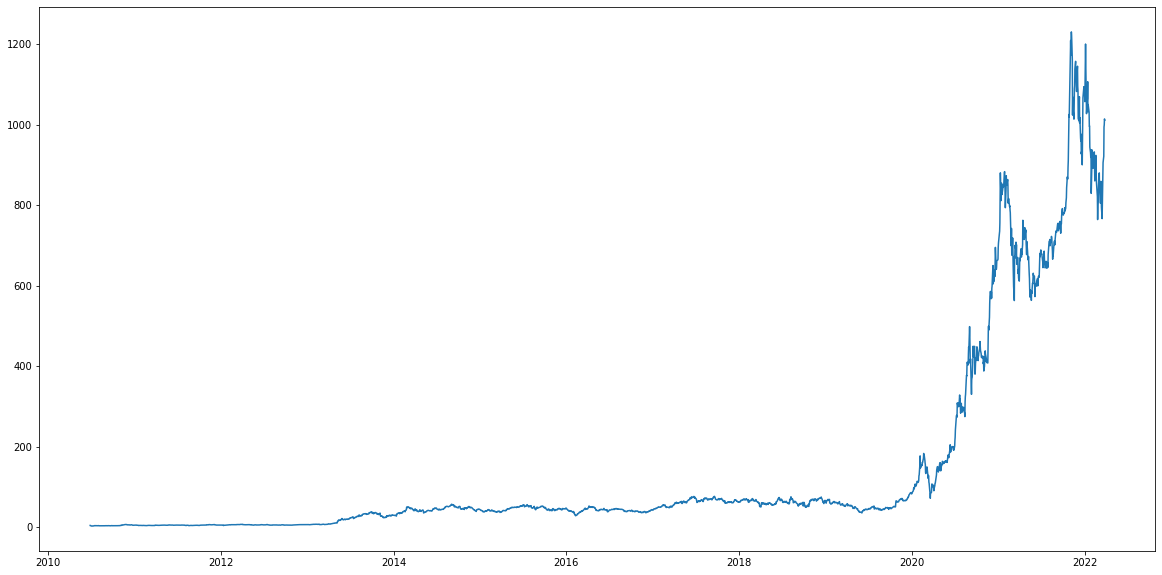

In [5]:
plt.figure(figsize=(20,10))
plt.plot(stock)

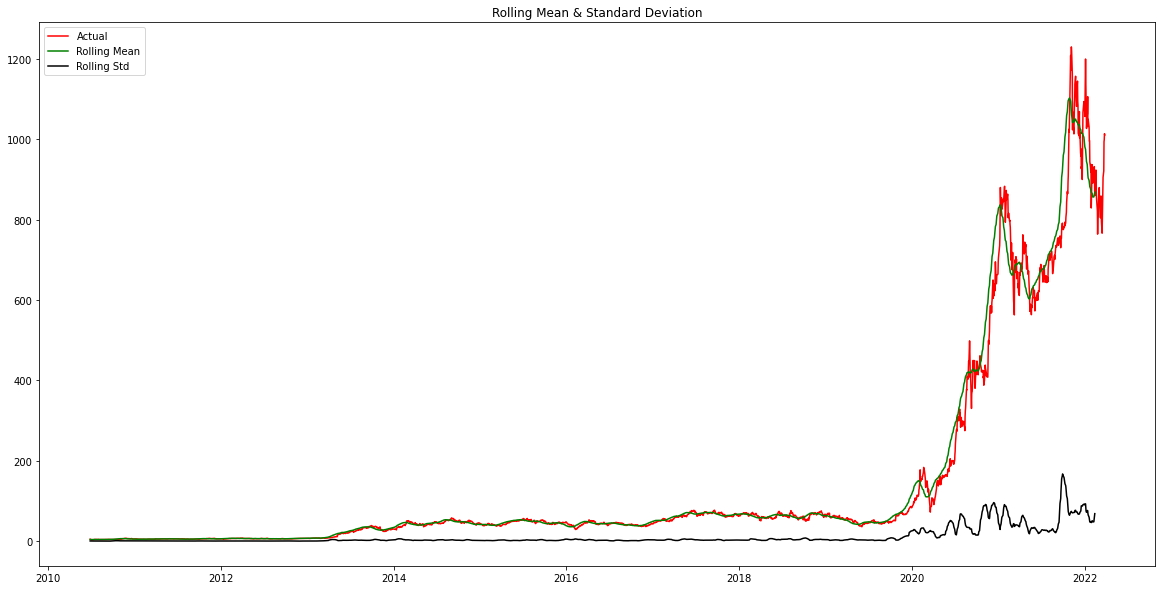

In [6]:
rolmean=stock.rolling(window=30).mean()
rolstd=stock.rolling(window=30).std()

plt.figure(figsize=(20,10))
actual=plt.plot(stock, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

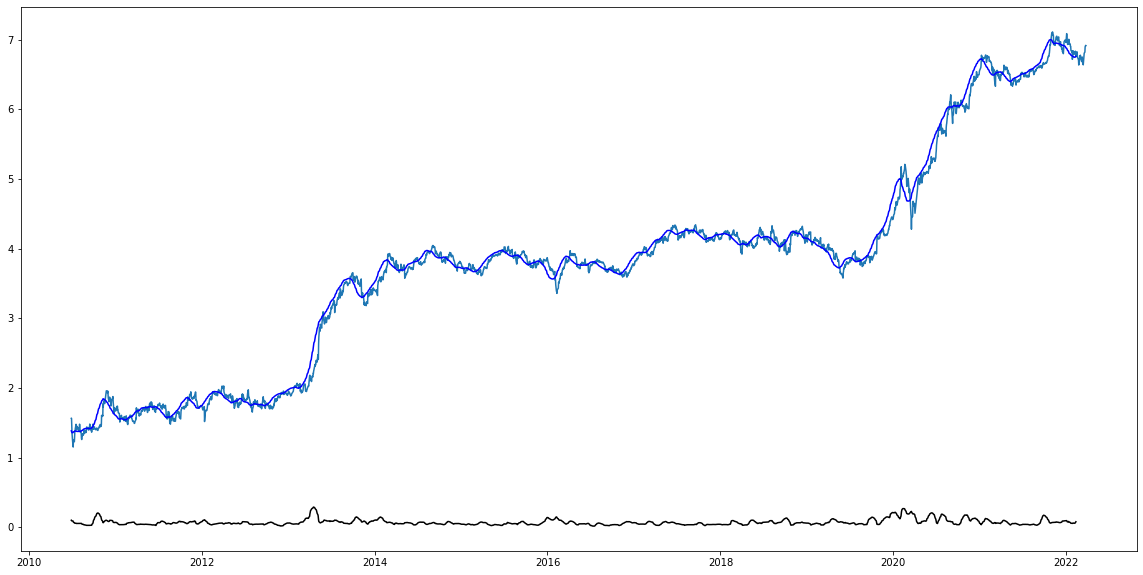

In [7]:
#log transform

ts_log=np.log(stock)
plt.figure(figsize=(20,10))
MAvg=ts_log.rolling(window=30).mean()
MStd=ts_log.rolling(window=30).std()
plt.plot(ts_log)
plt.plot(MStd, color='black')
plt.plot(MAvg, color='blue')

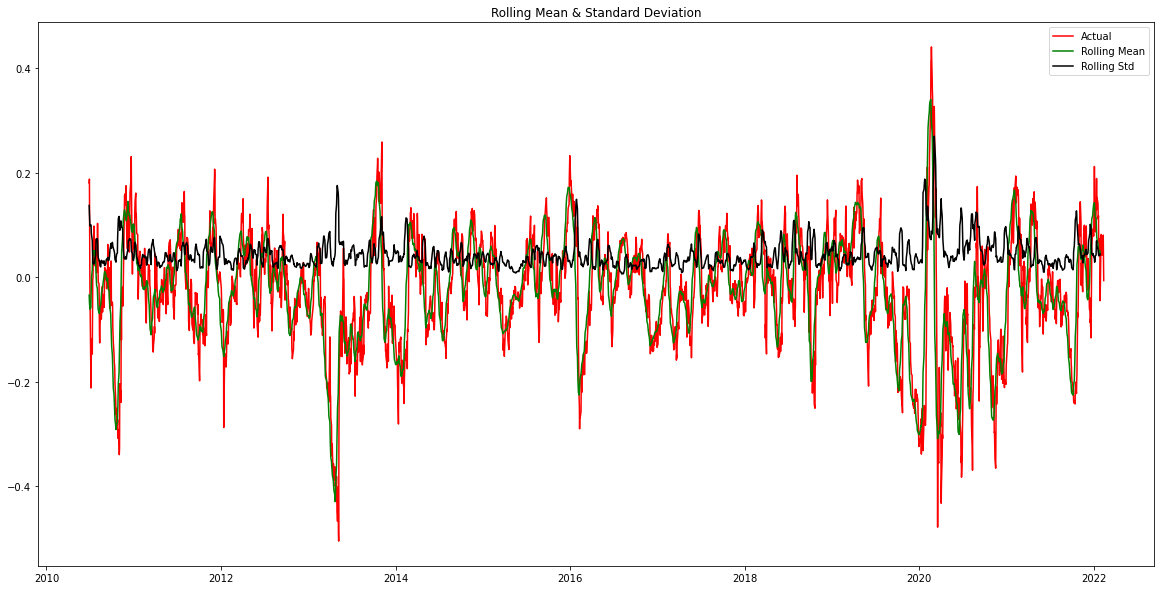

Dickey-Fuller Test: 
Test Statistic         -8.958589e+00
p-value                 8.342912e-15
Lags Used               3.000000e+00
No. of Obs              2.924000e+03
Critical Value (1%)    -3.432588e+00
Critical Value (5%)    -2.862529e+00
Critical Value (10%)   -2.567296e+00
dtype: float64


In [8]:
# log difference

ts_log_diff=ts_log-MAvg
ts_log_diff=ts_log_diff.dropna()

analyze_ts(ts_log_diff)

#### ARIMA

Text(0.5, 1.0, 'Partial Autocorrelation Function')

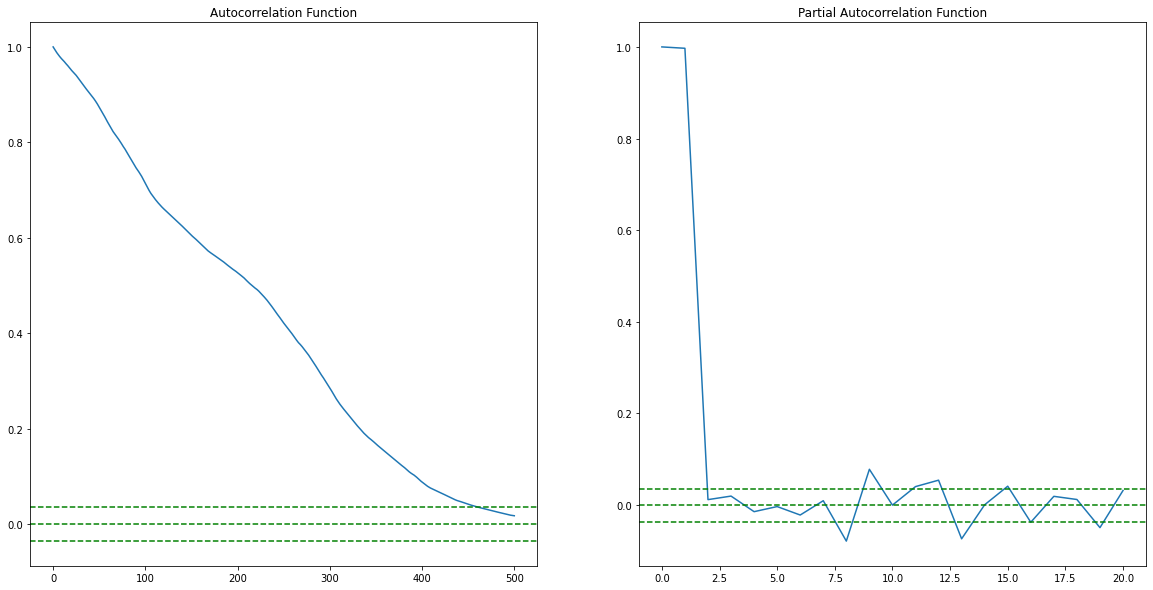

In [9]:
lag_acf=acf(stock, nlags=500)
lag_pacf=pacf(stock, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

In [11]:
#based on the plot we use p=2, q=475

###############takes very long
model = ARIMA(stock, order=(2,0,475))
model = model.fit()
pred = model.predict()
plot_and_rss(stock, pred)

C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it is not monotonic and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index

In [ ]:
# Plot residual errors
plt.figure(figsize=(20,10))
plt.plot(stock["close"]-pred, color="black")
plt.title('Residual errors')
plt.show()

#plot kde
plt.figure(figsize=(20,10))
plt.title("KDE")
sns.kdeplot(stock["close"]-pred)

In [ ]:
pred = model.get_forecast(120)

pred_val = pred.predicted_mean
pred_confint = pred.conf_int(alpha=0.05)

plt.figure(figsize=(20,10))
plt.plot(pred_val, color="black")
plt.plot(pred_confint["lower close"], "b--")
plt.plot(pred_confint["upper close"], "b--")
plt.title('Prediction next 10 years')

## Same but per month

In [15]:
stock = pd.read_csv('data/needed/cleaned/Stock.csv', usecols=["date", "close"])
stock["date"] = pd.to_datetime(stock["date"])
stock["month"] = stock["date"].dt.to_period('M')
monthly = stock.groupby("month")
stock_m = monthly.mean()
stock_m.index = stock_m.index.to_timestamp()
print(stock_m.head())

               close
month               
2010-06-01  4.772000
2010-07-01  3.911619
2010-08-01  3.902182
2010-09-01  4.148095
2010-10-01  4.142667


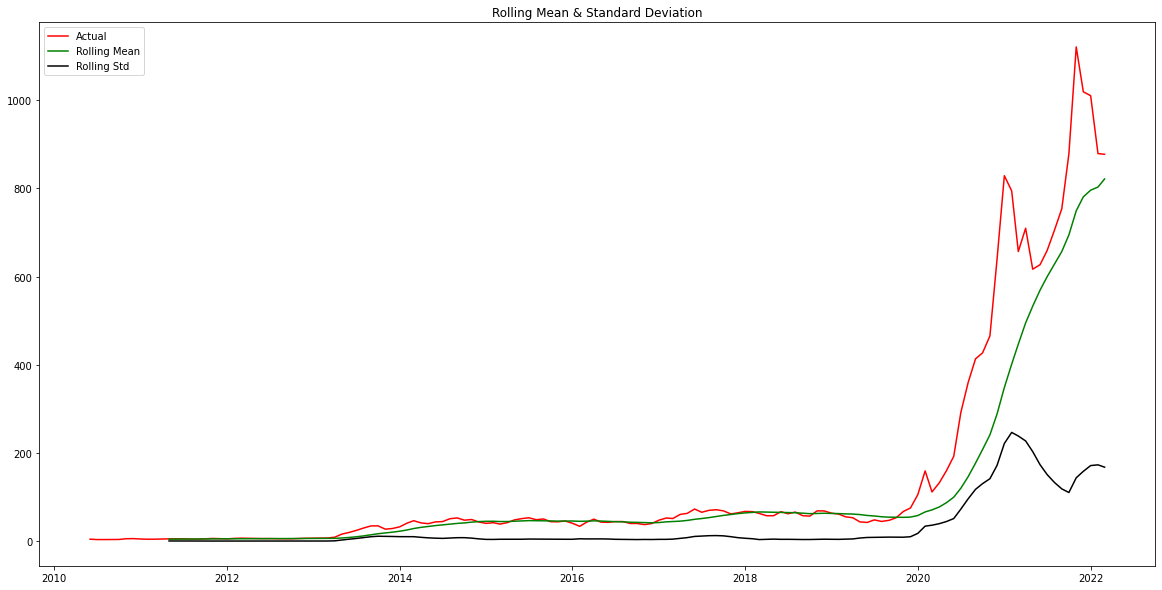

In [16]:
rolmean=stock_m.rolling(window=12).mean()
rolstd=stock_m.rolling(window=12).std()

plt.figure(figsize=(20,10))
actual=plt.plot(stock_m, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

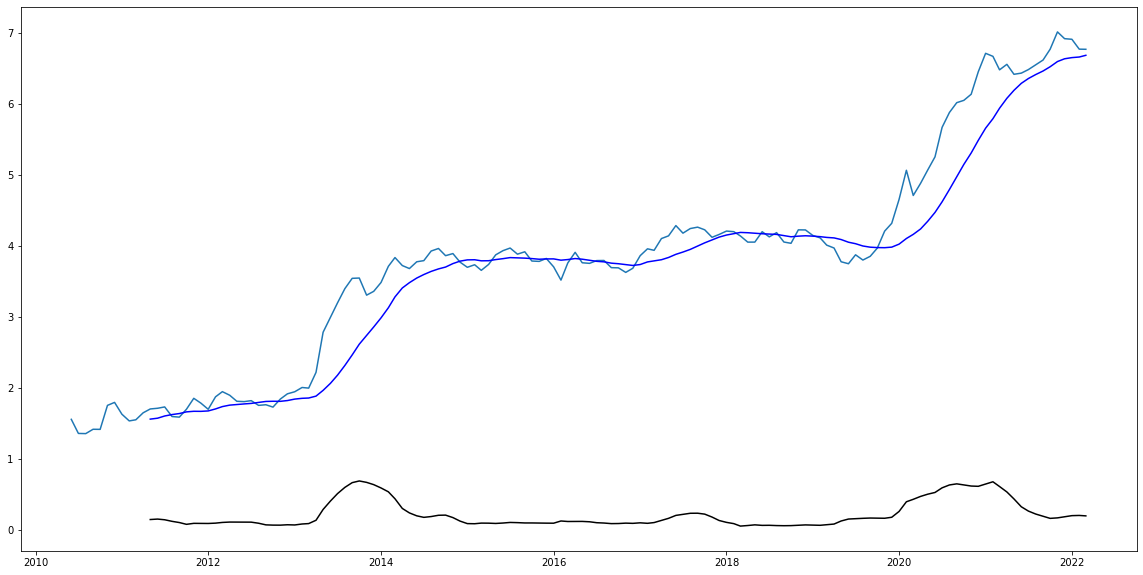

In [17]:
#log transform

ts_log=np.log(stock_m)
plt.figure(figsize=(20,10))
MAvg=ts_log.rolling(window=12).mean()
MStd=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(MStd, color='black')
plt.plot(MAvg, color='blue')

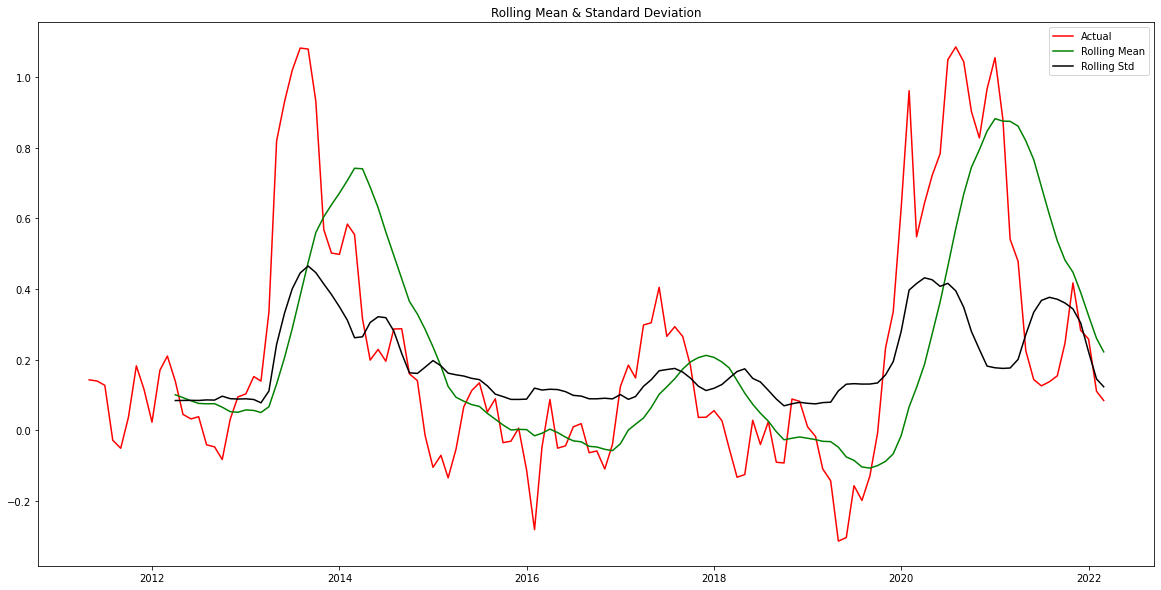

Dickey-Fuller Test: 
Test Statistic           -2.713698
p-value                   0.071698
Lags Used                 1.000000
No. of Obs              129.000000
Critical Value (1%)      -3.482088
Critical Value (5%)      -2.884219
Critical Value (10%)     -2.578864
dtype: float64


In [18]:
# log difference

ts_log_diff=ts_log-MAvg
ts_log_diff=ts_log_diff.dropna()

analyze_ts(ts_log_diff)

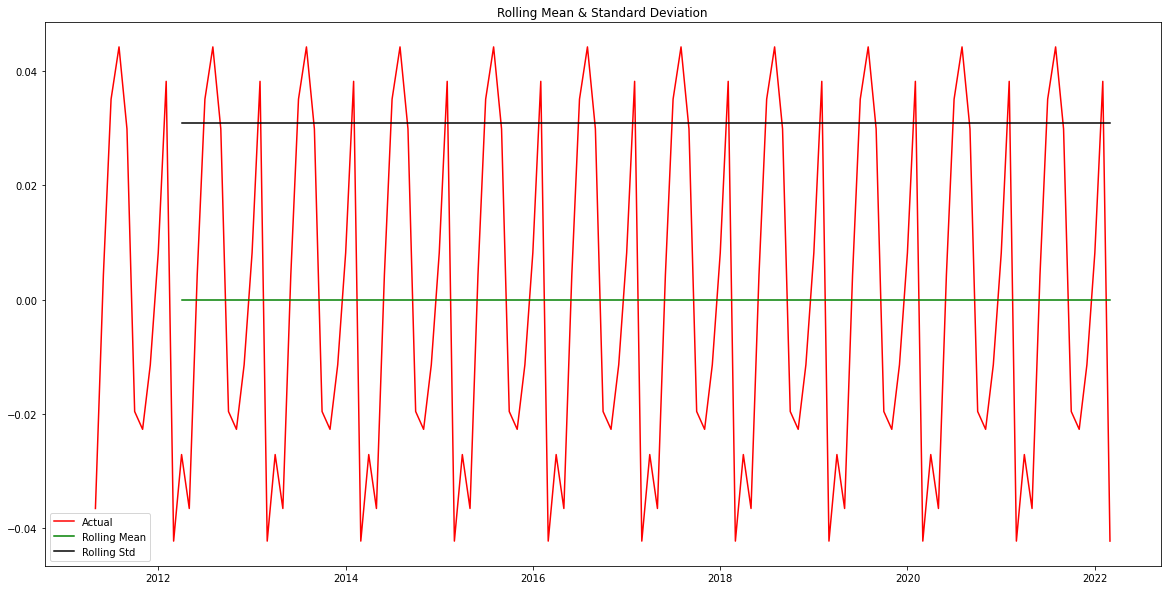

Dickey-Fuller Test: 
Test Statistic         -1.850391e+15
p-value                 0.000000e+00
Lags Used               1.100000e+01
No. of Obs              1.190000e+02
Critical Value (1%)    -3.486535e+00
Critical Value (5%)    -2.886151e+00
Critical Value (10%)   -2.579896e+00
dtype: float64


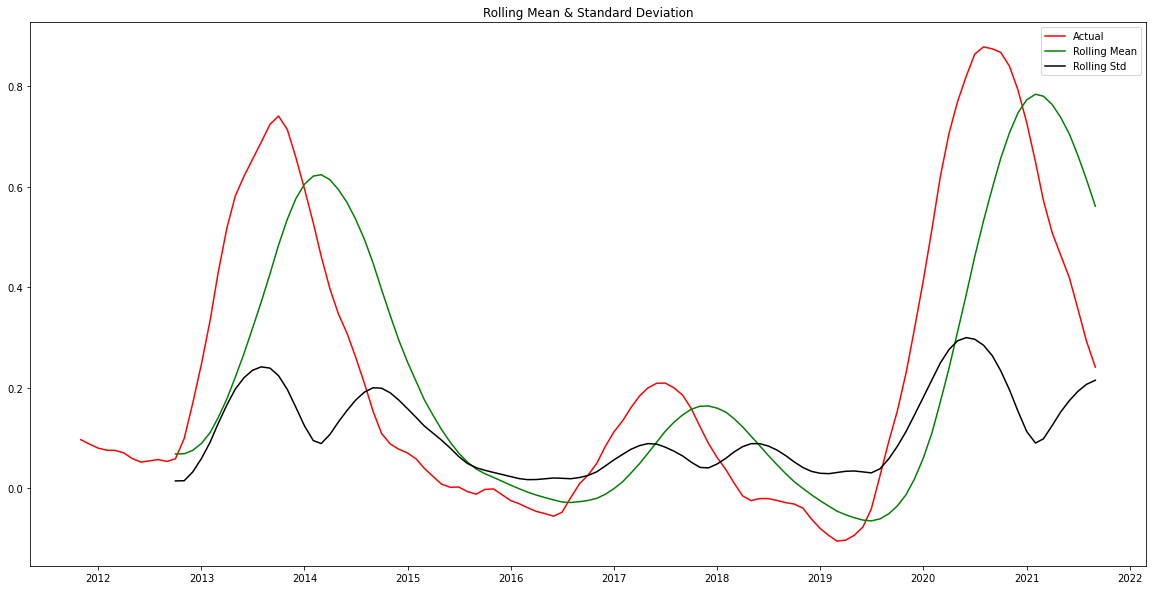

Dickey-Fuller Test: 
Test Statistic           -2.820883
p-value                   0.055352
Lags Used                12.000000
No. of Obs              106.000000
Critical Value (1%)      -3.493602
Critical Value (5%)      -2.889217
Critical Value (10%)     -2.581533
dtype: float64


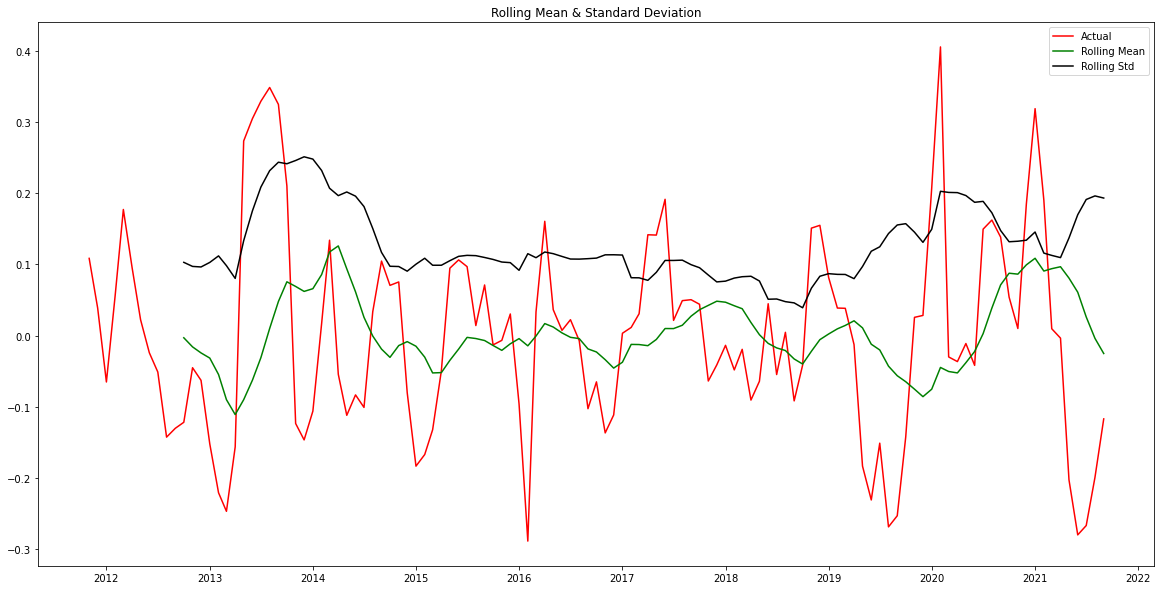

Dickey-Fuller Test: 
Test Statistic         -5.768872e+00
p-value                 5.451156e-07
Lags Used               3.000000e+00
No. of Obs              1.150000e+02
Critical Value (1%)    -3.488535e+00
Critical Value (5%)    -2.887020e+00
Critical Value (10%)   -2.580360e+00
dtype: float64


In [19]:
#seasonal decomposition
decomp = seasonal_decompose(ts_log_diff)
analyze_ts(decomp.seasonal)
analyze_ts(decomp.trend.dropna())
analyze_ts(decomp.resid.dropna())

#### ARIMA

Text(0.5, 1.0, 'Partial Autocorrelation Function')

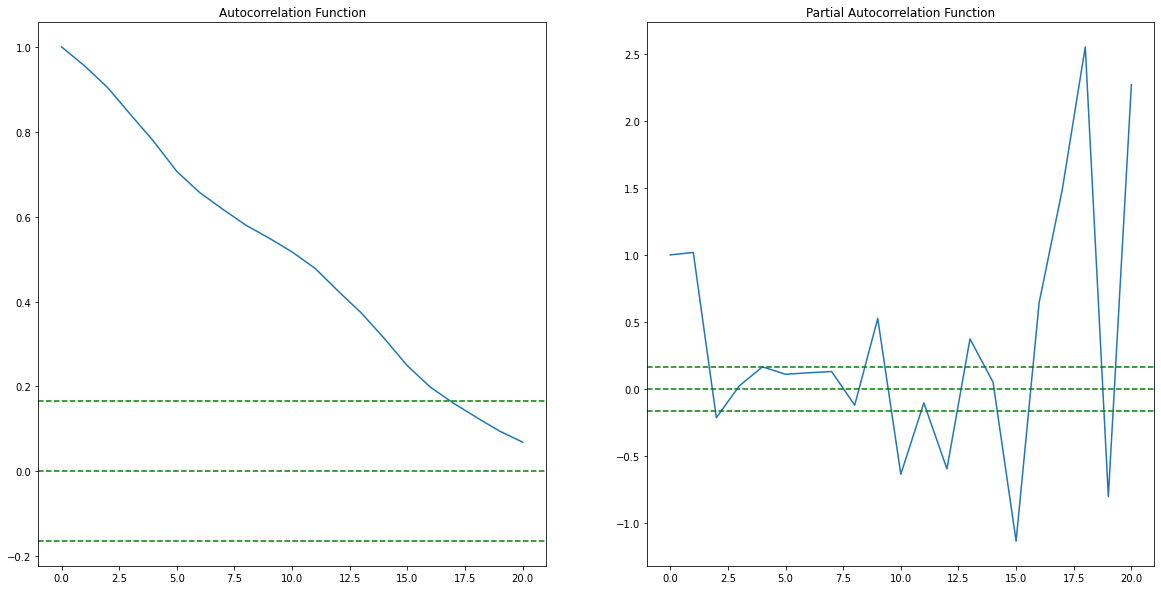

In [49]:
lag_acf=acf(stock_m, nlags=20)
lag_pacf=pacf(stock_m, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


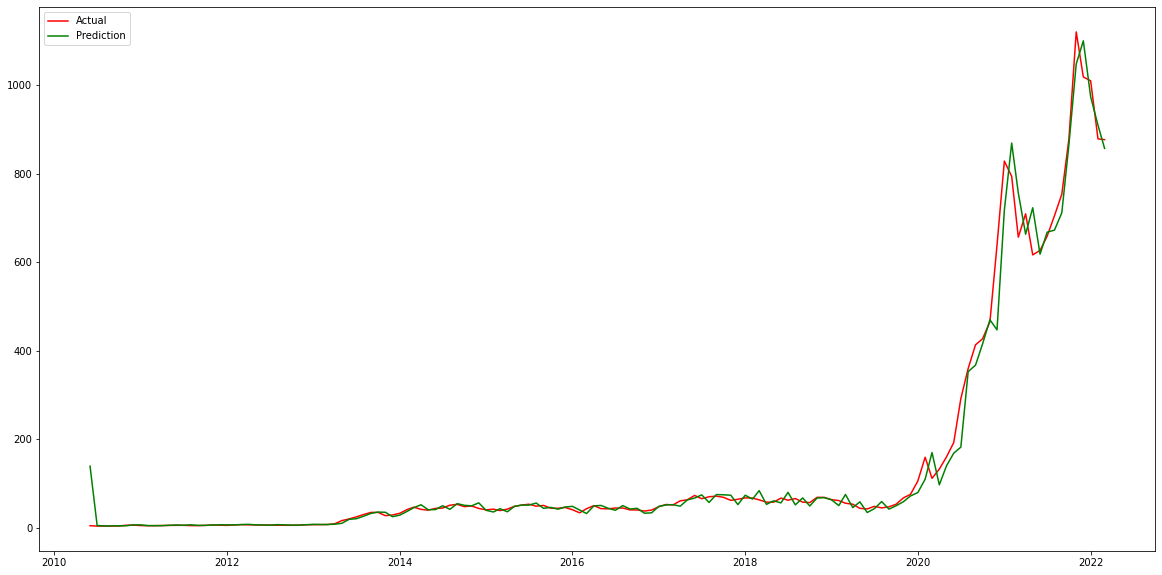

RSS: 141576.66822985193


In [51]:
#based on the plot we use p=2, q=17

model = ARIMA(stock_m, order=(2,0,17))
model = model.fit()
pred = model.predict()
plot_and_rss(stock_m, pred)

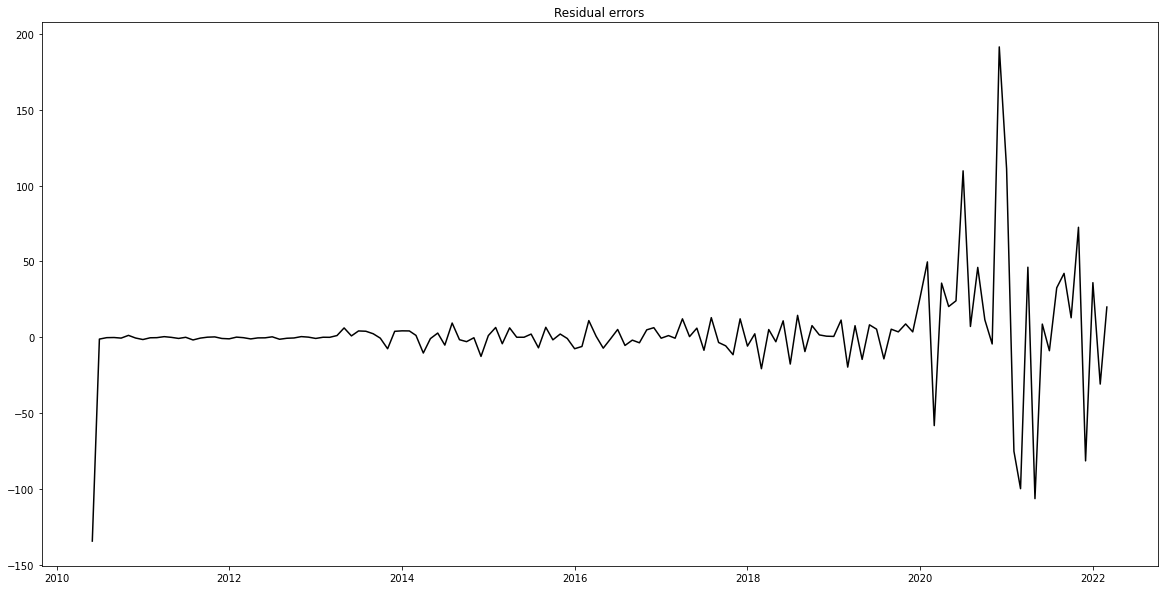

<AxesSubplot:title={'center':'KDE'}, ylabel='Density'>

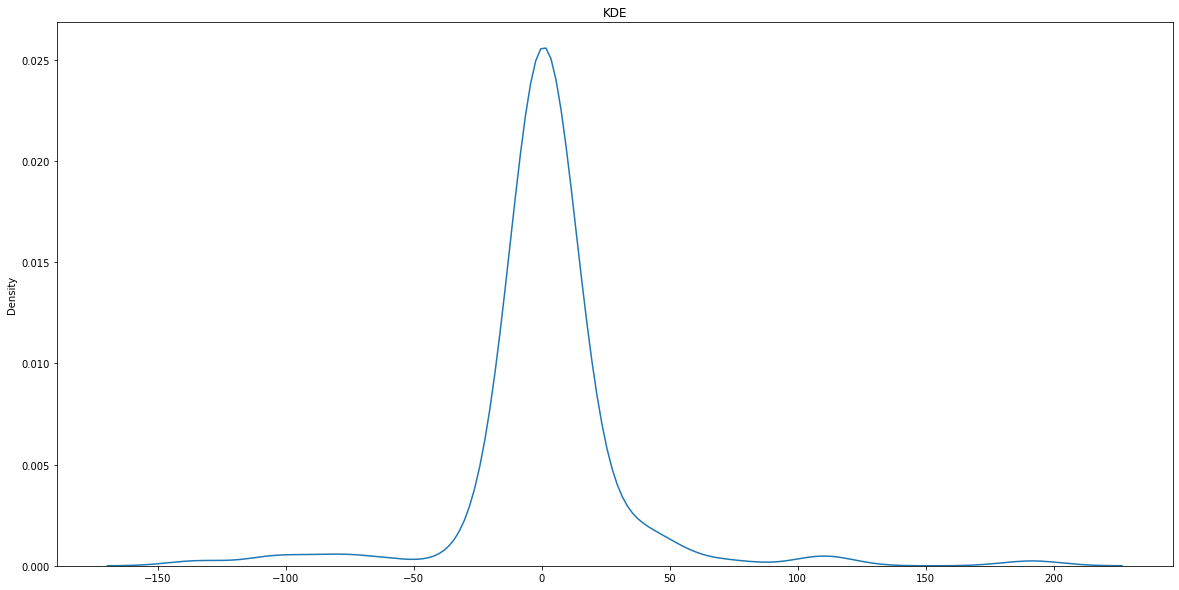

In [54]:
# Plot residual errors
plt.figure(figsize=(20,10))
plt.plot(stock_m["close"]-pred, color="black")
plt.title('Residual errors')
plt.show()

#plot kde
plt.figure(figsize=(20,10))
plt.title("KDE")
sns.kdeplot(stock_m["close"]-pred)

Text(0.5, 1.0, 'Prediction next 10 years')

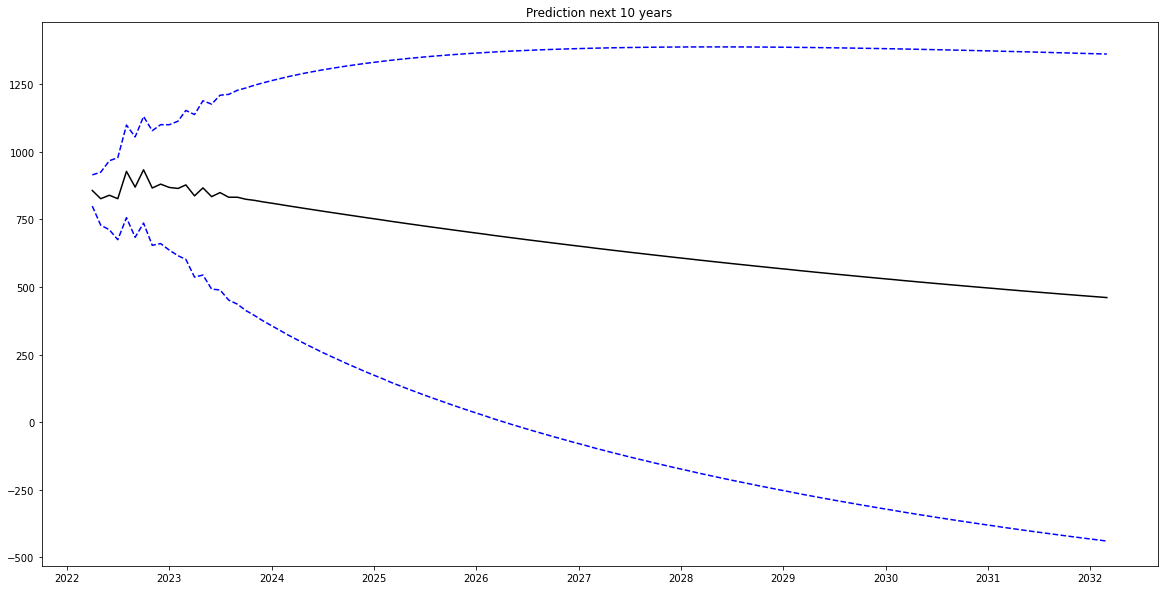

In [56]:
pred = model.get_forecast(120)

pred_val = pred.predicted_mean
pred_confint = pred.conf_int(alpha=0.05)

plt.figure(figsize=(20,10))
plt.plot(pred_val, color="black")
plt.plot(pred_confint["lower close"], "b--")
plt.plot(pred_confint["upper close"], "b--")
plt.title('Prediction next 10 years')

## per month 2014 - 2019

In [24]:
stock = pd.read_csv('data/needed/cleaned/Stock.csv', usecols=["date", "close"])
stock["date"] = pd.to_datetime(stock["date"])
stock = stock[stock.date > "2013.12.31"]
stock = stock[stock.date < "2020.1.1"]
stock["month"] = stock["date"].dt.to_period('M')
monthly = stock.groupby("month")
stock_m = monthly.mean()
stock_m.index = stock_m.index.to_timestamp()
print(stock_m.head())

                close
month                
2014-01-01  32.810381
2014-02-01  41.204631
2014-03-01  46.629333
2014-04-01  41.657524
2014-05-01  39.934857


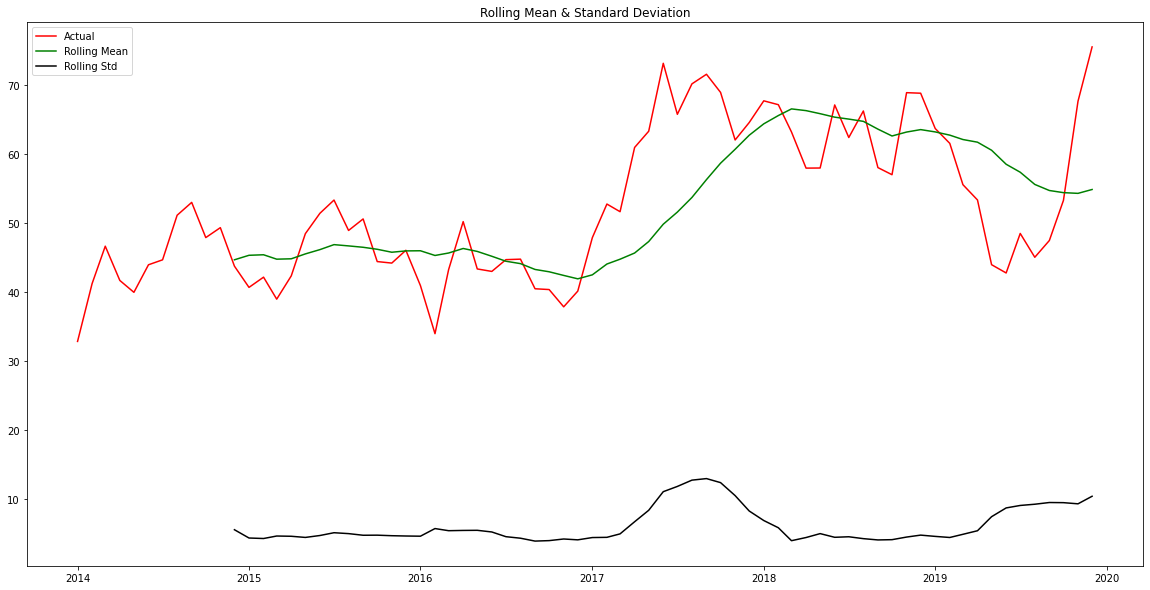

In [25]:
rolmean=stock_m.rolling(window=12).mean()
rolstd=stock_m.rolling(window=12).std()

plt.figure(figsize=(20,10))
actual=plt.plot(stock_m, color='red', label='Actual')
mean_6=plt.plot(rolmean, color='green', label='Rolling Mean') 
std_6=plt.plot(rolstd, color='black', label='Rolling Std')
plt.legend(loc='best')
plt.title('Rolling Mean & Standard Deviation')
plt.show(block=False)

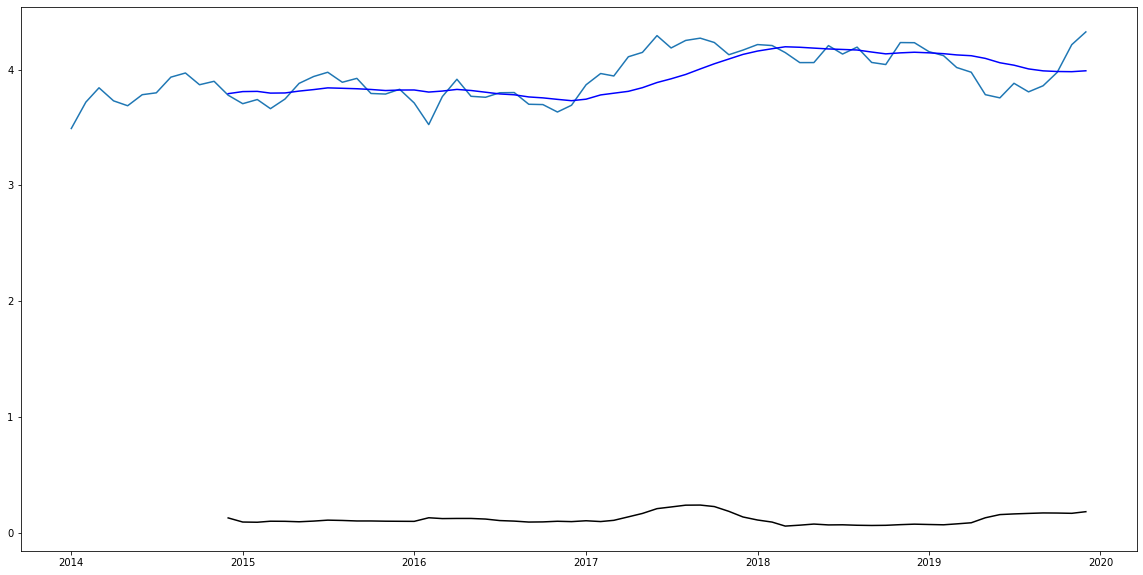

In [26]:
#log transform

ts_log=np.log(stock_m)
plt.figure(figsize=(20,10))
MAvg=ts_log.rolling(window=12).mean()
MStd=ts_log.rolling(window=12).std()
plt.plot(ts_log)
plt.plot(MStd, color='black')
plt.plot(MAvg, color='blue')

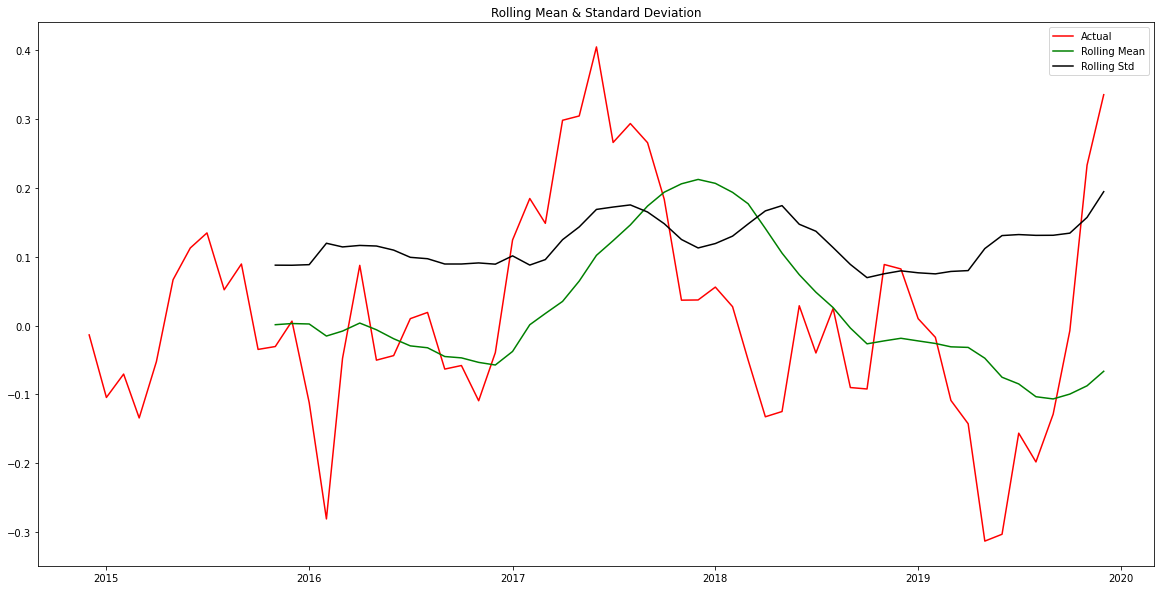

Dickey-Fuller Test: 
Test Statistic          -3.107635
p-value                  0.025993
Lags Used                4.000000
No. of Obs              56.000000
Critical Value (1%)     -3.552928
Critical Value (5%)     -2.914731
Critical Value (10%)    -2.595137
dtype: float64


In [27]:
# log difference

ts_log_diff=ts_log-MAvg
ts_log_diff=ts_log_diff.dropna()

analyze_ts(ts_log_diff)

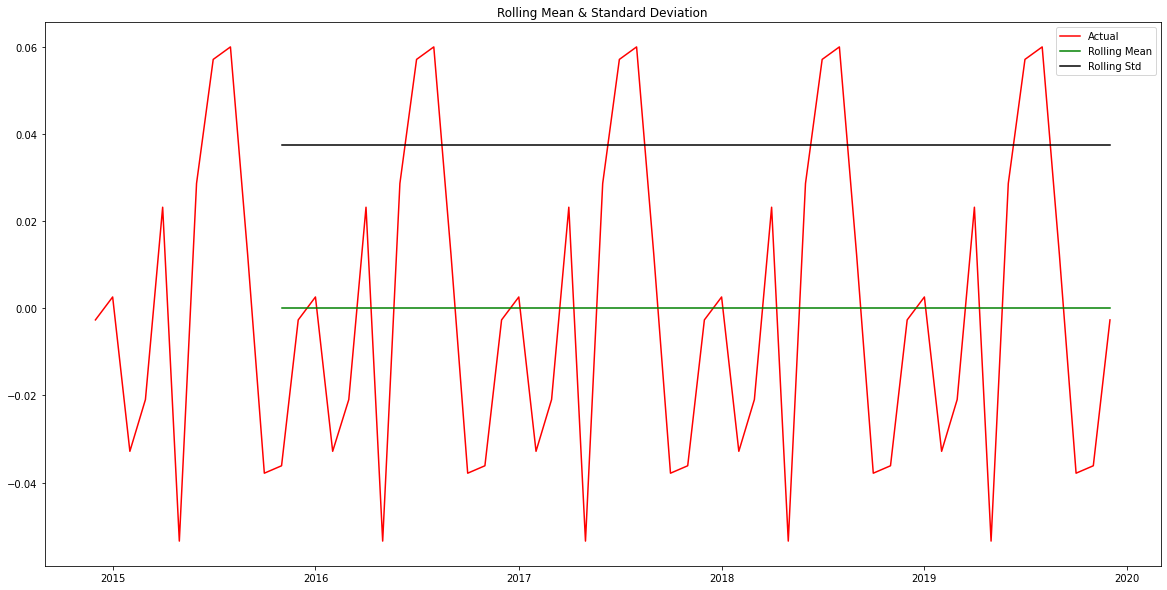

Dickey-Fuller Test: 
Test Statistic         -2.260538e+13
p-value                 0.000000e+00
Lags Used               1.100000e+01
No. of Obs              4.900000e+01
Critical Value (1%)    -3.571472e+00
Critical Value (5%)    -2.922629e+00
Critical Value (10%)   -2.599336e+00
dtype: float64


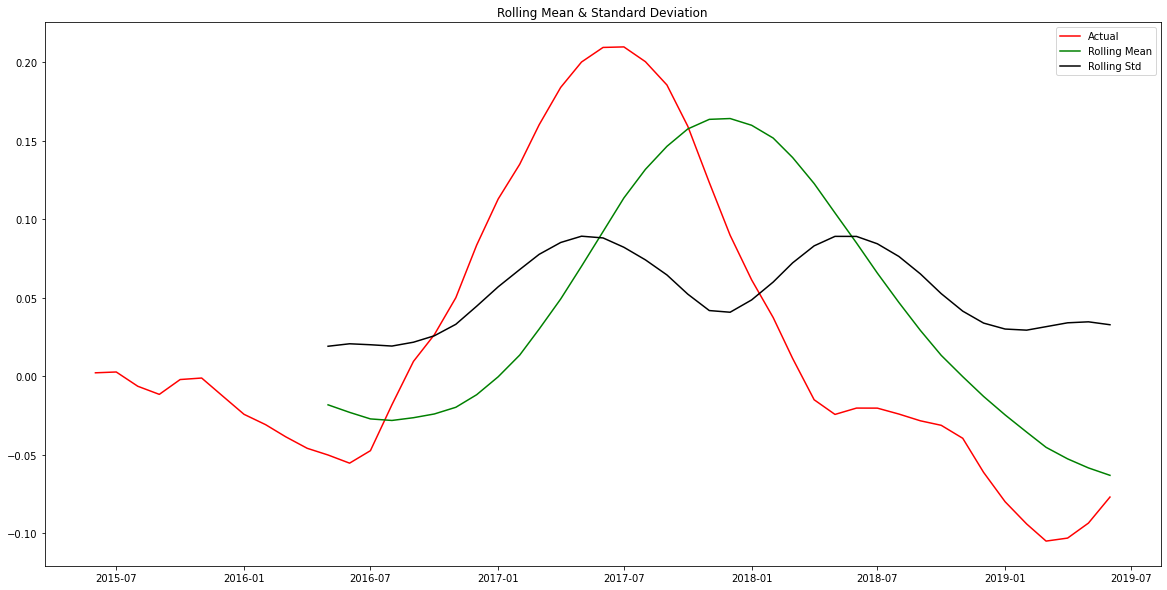

Dickey-Fuller Test: 
Test Statistic          -4.308620
p-value                  0.000429
Lags Used                9.000000
No. of Obs              39.000000
Critical Value (1%)     -3.610400
Critical Value (5%)     -2.939109
Critical Value (10%)    -2.608063
dtype: float64


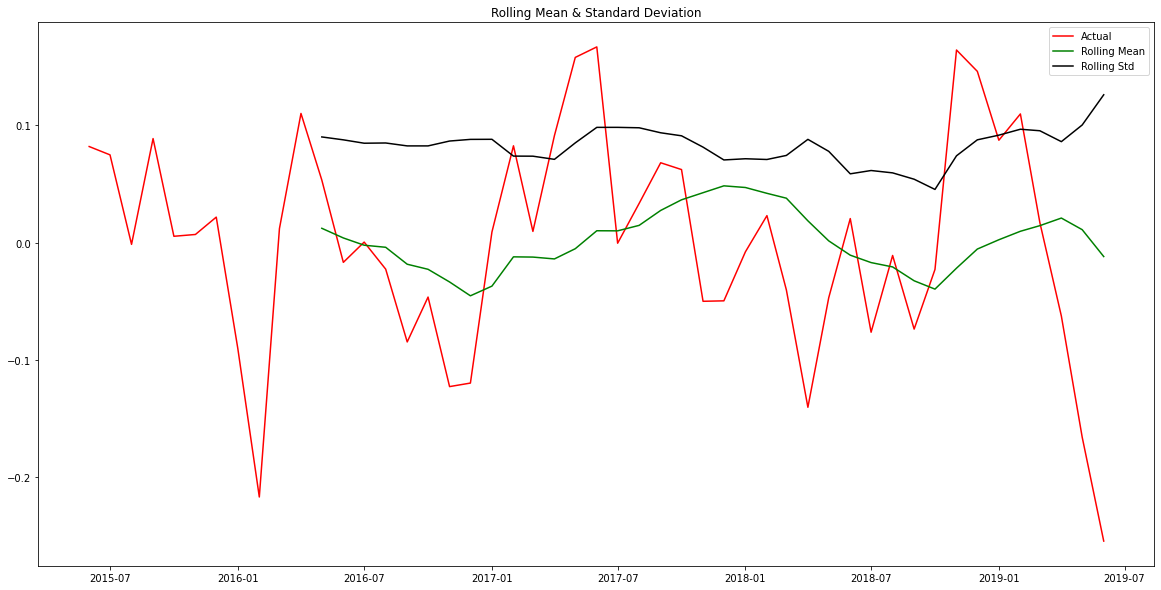

Dickey-Fuller Test: 
Test Statistic          -3.475826
p-value                  0.008630
Lags Used                5.000000
No. of Obs              43.000000
Critical Value (1%)     -3.592504
Critical Value (5%)     -2.931550
Critical Value (10%)    -2.604066
dtype: float64


In [28]:
#seasonal decomposition
decomp = seasonal_decompose(ts_log_diff)
analyze_ts(decomp.seasonal)
analyze_ts(decomp.trend.dropna())
analyze_ts(decomp.resid.dropna())

#### ARIMA

Text(0.5, 1.0, 'Partial Autocorrelation Function')

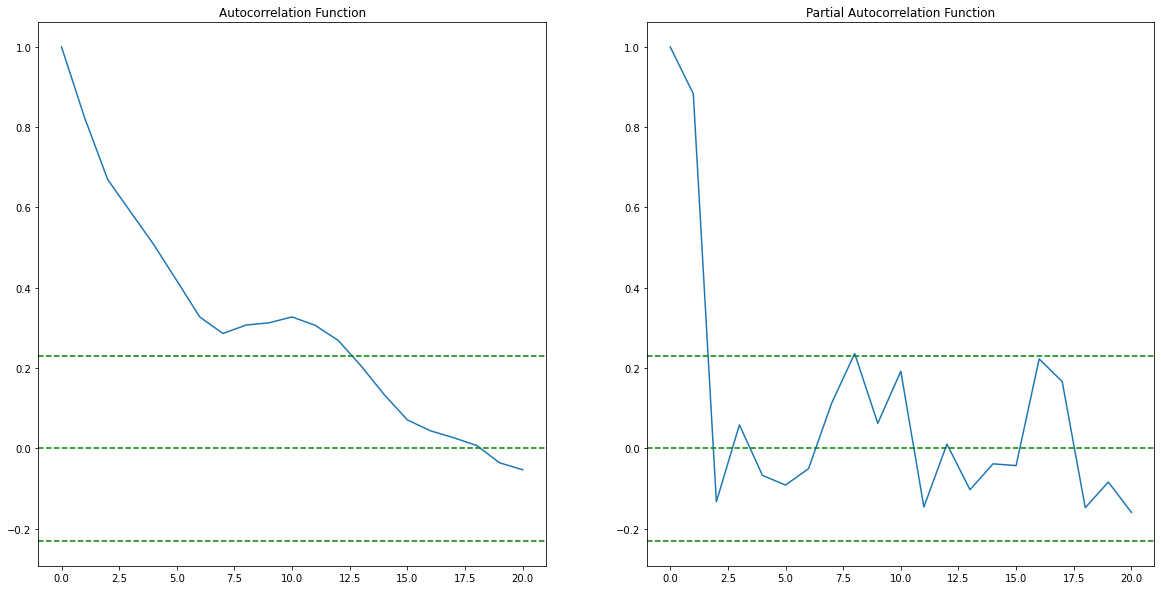

In [29]:
lag_acf=acf(stock_m, nlags=20)
lag_pacf=pacf(stock_m, nlags=20, method='ols')

plt.figure(figsize=(20,10))
plt.subplot(121)
plt.plot(lag_acf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.title('Autocorrelation Function')

plt.subplot(122)
plt.plot(lag_pacf)
plt.axhline(y=0,linestyle='--',color='green')
plt.axhline(y=-1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.axhline(y=1.96/np.sqrt(len(stock_m)),linestyle='--',color='green')
plt.title('Partial Autocorrelation Function')

C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ChristianMatter\AppData\Local\Programs\Python\Python39\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


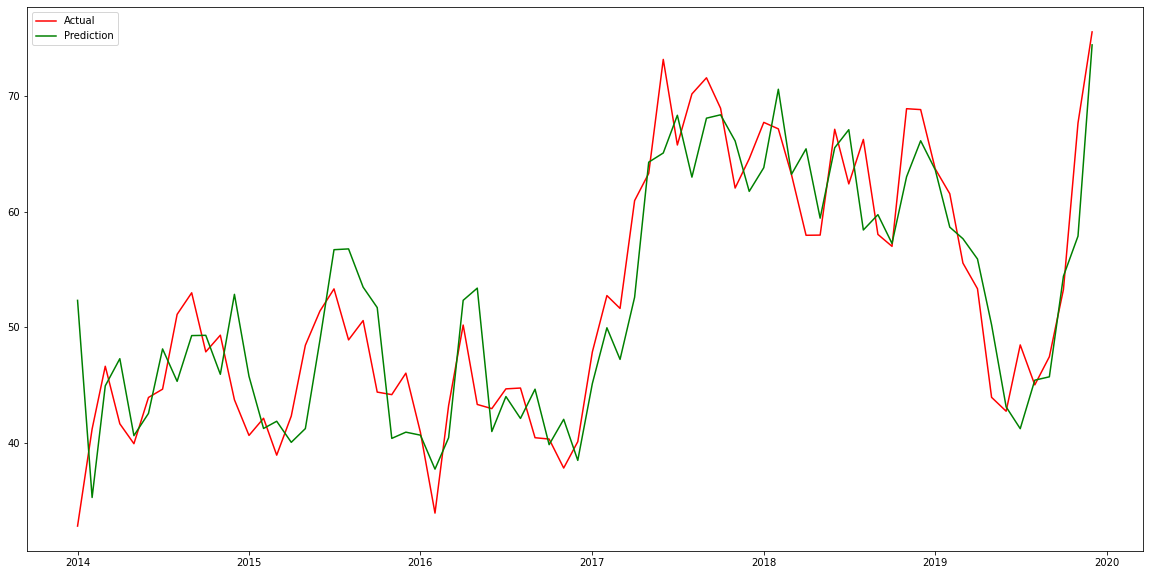

RSS: 1755.2479761641493


In [30]:
#based on the plot we use p=2, q=14

model = ARIMA(stock_m, order=(2,0,14))
model = model.fit()
pred = model.predict()
plot_and_rss(stock_m, pred)

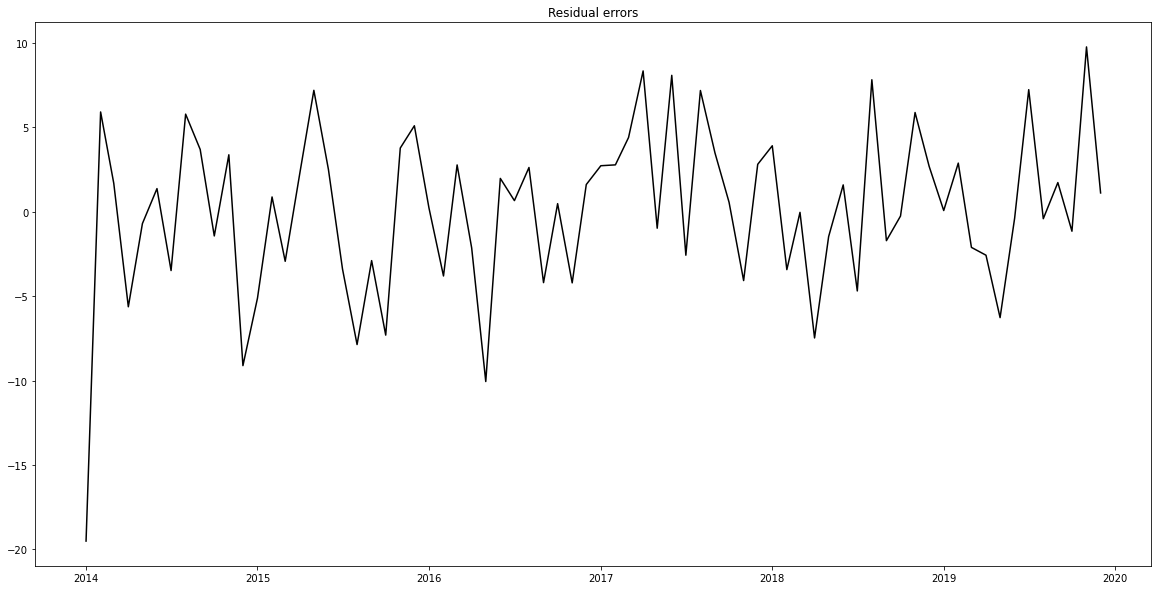

<AxesSubplot:title={'center':'KDE'}, ylabel='Density'>

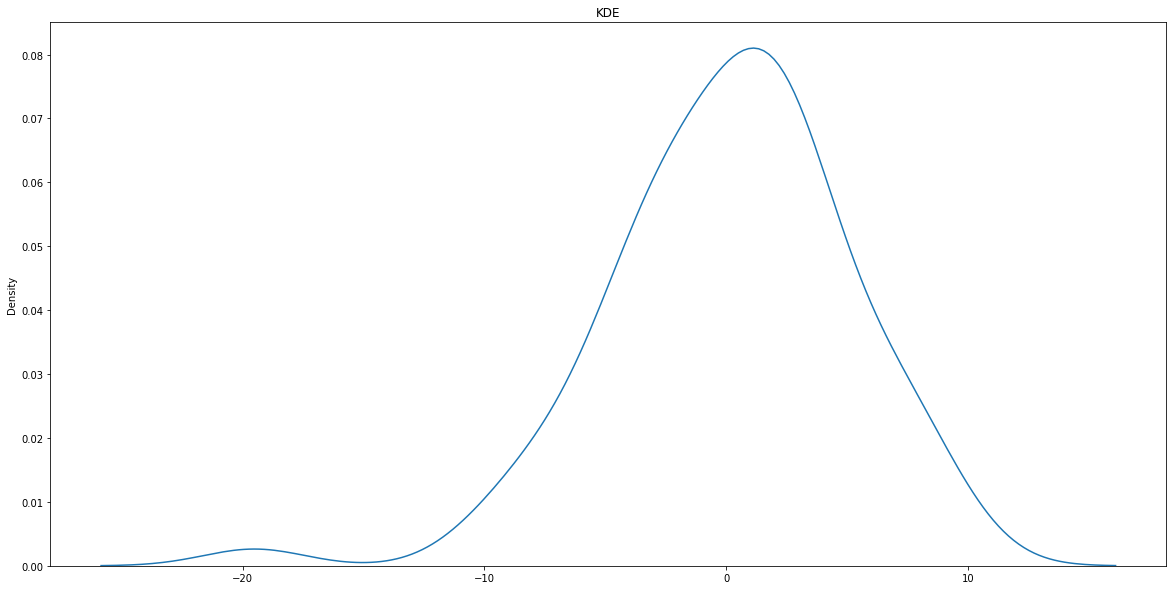

In [31]:
# Plot residual errors
plt.figure(figsize=(20,10))
plt.plot(stock_m["close"]-pred, color="black")
plt.title('Residual errors')
plt.show()

#plot kde
plt.figure(figsize=(20,10))
plt.title("KDE")
sns.kdeplot(stock_m["close"]-pred)

Text(0.5, 1.0, 'Prediction next 10 years')

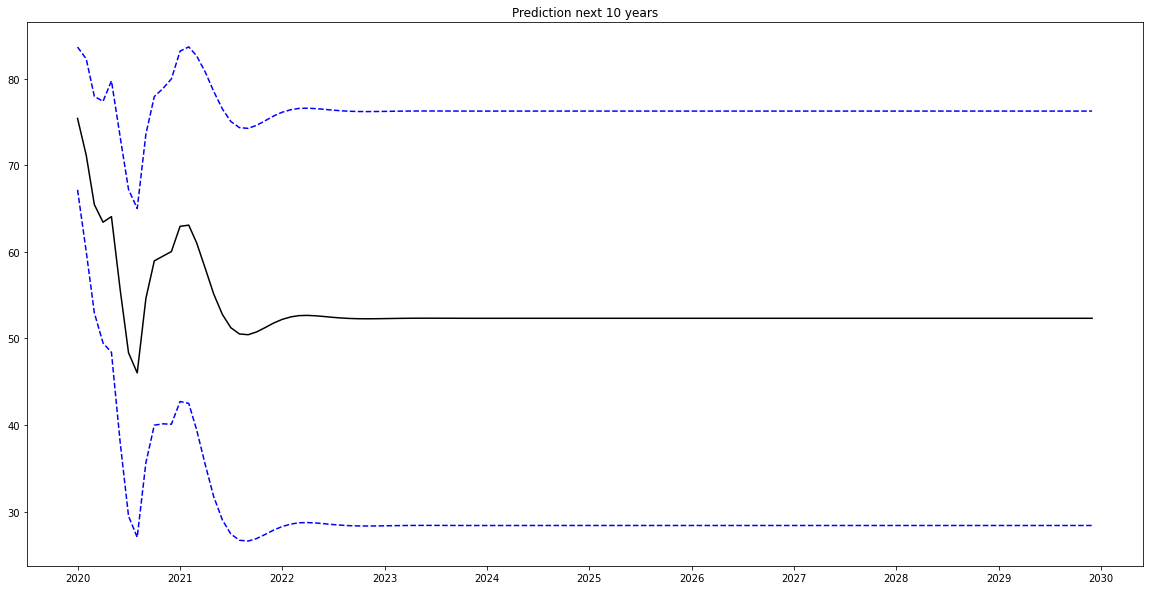

In [32]:
pred = model.get_forecast(120)

pred_val = pred.predicted_mean
pred_confint = pred.conf_int(alpha=0.05)

plt.figure(figsize=(20,10))
plt.plot(pred_val, color="black")
plt.plot(pred_confint["lower close"], "b--")
plt.plot(pred_confint["upper close"], "b--")
plt.title('Prediction next 10 years')